In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries here

In [2]:
import torch
from torch import nn
import torch.nn.functional as f
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.models as models
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116
Using the GPU!


Old VOC:

Download PASCAL VOC 2012 Dataset

In [ ]:
!wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

In [4]:
voc_root = "/content/VOCdevkit/VOC2012"

def read_images(root=voc_root, train=True):
    txt_file_add = root + '/ImageSets/Segmentation/' + ('train.txt' if train else 'val.txt')
    with open(txt_file_add, 'r') as f:
        images = f.read().split()
    img = [os.path.join(root, 'JPEGImages', i+'.jpg') for i in images]
    label = [os.path.join(root, 'SegmentationClass', i+'.png') for i in images]
    return img, label


Aug VOC:

This part is used to download VOC2012 Aug dataset if needed.

In [ ]:
# !unzip "/content/drive/MyDrive/FCN/Data_set/VOC2012Aug.zip" -d "/content/VOC2012Aug/"

In [ ]:
# voc_root = "/content/VOC2012Aug"

# def read_images(root=voc_root, train=True):
#     txt_file_add = root + ('/train.txt' if train else '/val.txt')
#     with open(txt_file_add, 'r') as f:
#         images = f.read().split()
#     img = [os.path.join(root, 'img', i+'.jpg') for i in images]
#     label = [os.path.join(root, 'cls_aug_png', i+'.png') for i in images]
#     return img, label

Define crop function and random crop function to increase diveristy of images

In [5]:
def crop(img, label, height, width):
    """
    data and label are image
    """
    box = (0, 0, width, height)
    img = img.crop(box)
    label = label.crop(box)
    return img, label

In [6]:
# Random crop image and label
def voc_rand_crop(image, label, height, width):
    i, j, h, w = transforms.RandomCrop.get_params(
        image, output_size=(height, width))
    # Use crop function to resize the images and their labels
    image = transforms.functional.crop(image, i, j, h, w)
    label = transforms.functional.crop(label, i, j, h, w)

    return image, label

Label classes matrix and colormap is defined here.

In [7]:
# Label classes matrix
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

# Label classes RGB values matrix
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

In [8]:
# Create a mapping from RGB values to labels
rgb_to_label = np.zeros(256**3)

# Populate the mapping using the colormap
for pos, color in enumerate(colormap):
    # Compute the index in the rgb_to_label array for this color
    index = (color[0]*256 + color[1])*256 + color[2]
    rgb_to_label[index] = pos

def map_image_to_label(image):
    """
    Maps an image with a colormap to a label map.
    
    Parameters:
        image (np.ndarray): The image with a colormap.
        
    Returns:
        np.ndarray: The label map corresponding to the input image.
    """
    # Convert the image to an integer array
    image_data = np.array(image, dtype="int32")
    # Compute the index in the rgb_to_label array for each pixel in the image
    indices = (image_data[:,:,0]*256 + image_data[:,:,1])*256 + image_data[:,:,2]
    # Map the indices to labels using the rgb_to_label array
    return np.array(rgb_to_label[indices], dtype="int64")

In [9]:
def image_transforms(image, label, height, width):
    image, label = voc_rand_crop(image, label, height, width)
    # Normalize the input image
    img_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = img_transforms(image)
    label = map_image_to_label(label)
    label = torch.from_numpy(label)
    return image, label

Define VOCDataset

In [23]:
class VOCDataset(torch.utils.data.Dataset):
    
    def __init__(self, train, transforms, crop_size = (224, 224)):
        self.filtered_num = 0    # Count the image being filtered
        self.crop_size = crop_size #Crop size needed
        self.transforms = transforms
        img_list, label_list = read_images(train=train)
        self.img_list = self.filter(img_list)
        self.label_list = self.filter(label_list)
        if(train==True):
            print("Train: Load " + str(len(self.img_list)) + " pictures and label" + "Filtered: " + str(self.filtered_num) + " pictures")
        else:
            print("Val：Load " + str(len(self.img_list)) + " pictures and label" + "Filtered: " + str(self.filtered_num) + " pictures")
        
    
    # Filter those images whose size is smaller than fixed size
    def filter(self, images):
      image_lst = []
      for image_path in images:
        image = Image.open(image_path)
        size = image.size
        if size[1] >= self.crop_size[0] and size[0] >= self.crop_size[1]:
          image_lst.append(image_path)
        else:
          self.filtered_num += 1
      return image_lst
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.transforms(img, label, self.crop_size[0], self.crop_size[1])
        return img, label
    
    def __len__(self):
        return len(self.img_list)

In [24]:
voc_train = VOCDataset(True, image_transforms)
voc_test = VOCDataset(False, image_transforms)

train_data = DataLoader(voc_train, batch_size=8, shuffle=True)
valid_data = DataLoader(voc_test, batch_size=8)

Train: Load 1456 pictures and labelFiltered: 16 pictures
Val：Load 1436 pictures and labelFiltered: 26 pictures


In [25]:
# Used to initialize ConvTrans' weight
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(np.array(weight))

In [26]:
# Load pretrained resnet34 weight
model_root = "/content/drive/MyDrive/FCN/RESNET34_pretrained/resnet34-333f7ec4.pth"
resnet_weight = models.resnet34()
pre_weight = torch.load(model_root)
resnet_weight.load_state_dict(pre_weight)
# Class Number
num_classes = len(classes)

Define FCN main body here.

In [37]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()
        
        self.stage1 = nn.Sequential(*list(resnet_weight.children())[:-4]) 
        self.stage2 = list(resnet_weight.children())[-4] 
        self.stage3 = list(resnet_weight.children())[-3] 
        
        self.dimredu1 = nn.Conv2d(512, num_classes, 1)
        self.dimredu2 = nn.Conv2d(256, num_classes, 1)
        self.dimredu3 = nn.Conv2d(128, num_classes, 1)
        
        # upsample 8 times
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # bilinear_kernel kernel
        # upsample 4 times
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # bilinear_kernel kernel
        # upsample 2 times
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # bilinear_kernel kernel

        
    def forward(self, x):
        x = self.stage1(x)
        stage1_output = x 
        x = self.stage2(x)
        stage2_output = x 
        x = self.stage3(x)
        stage3_output = x 
        
        stage3_output = self.dimredu1(stage3_output)     
        stage3_output = self.upsample_2x(stage3_output) 
        stage2_output = self.dimredu2(stage2_output)
        # Combine upsampled S3 with s2
        stage2_output = stage2_output + stage3_output 
        
        stage1_output = self.dimredu3(stage1_output)
        stage2_output = self.upsample_4x(stage2_output)
        final_pre_logit = stage1_output + stage2_output
 
        final_pre_logit = self.upsample_8x(final_pre_logit)   
        return final_pre_logit

Compute accuracy using Confusion Matrix

In [28]:
# Evaluate the accuracy, inspired by wkentaro's pytorch-fcn
# https://github.com/wkentaro/pytorch-fcn/blob/main/torchfcn/utils.py
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    """
    mask filter out the valid pixels in label_true
    label_true[mask] gives the true label of each pixels
    label_pred[mask] gives the predicted label of each pixels
    n_class * label_true[mask].astype(int) + label_pred[mask] stores n_class * true label + pred label for each pixel
    The combination of each n_class * true label + pred label is assigned with unique combination of one true label and one pred label
    np.bincount count the number of these combinations and listed as:
    [true_label, pred_label]:
    [
    0x0+0, 0x0+1, 0x0+2 ... 0x0+num_class,
    1x0+0, 1x0+1, 1x0+2 ... 1x0+num_class,
    ...
    ]
    Finally reshape to (n_class, n_class) matrix
    """
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

"""
label_trues Ground Truth
label_preds Predicted Labels
n_class number of classes
"""
def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean IoU
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
      hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    
    """
    acc: Pixel accuracy
    mean_iu: Mean IoU
    """
    acc = np.diag(hist).sum() / hist.sum()
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    return acc, mean_iu

In [39]:
FCN_net = fcn(num_classes)
if torch.cuda.is_available():
    FCN_net = FCN_net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(FCN_net.parameters(), lr=1e-2, weight_decay=1e-4)

Training:

In [ ]:
Epoch = 20

train_loss = []
train_accuracy = []
train_mean_IoU = []

valid_loss = []
valid_accuracy = []
valid_mean_IoU = []


for epoch in range(Epoch):
    
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    epoch_train_mean_IoU = 0
    
    FCN_net = FCN_net.train()
    for img_data, img_label in train_data:
        if torch.cuda.is_available:
            im = Variable(img_data).cuda()
            label = Variable(img_label).cuda()
        else:
            im = Variable(img_data)
            label = Variable(img_label)

        resnet_output = FCN_net(im)
        loss = criterion(resnet_output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        
        label_pred = resnet_output.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()

        acc, mean_iu = label_accuracy_score(label_true, label_pred, num_classes)
        epoch_train_accuracy += acc
        epoch_train_mean_IoU += mean_iu
    
    train_loss.append(epoch_train_loss/len(train_data))
    train_accuracy.append(epoch_train_accuracy/len(train_data))
    train_mean_IoU.append(epoch_train_mean_IoU/len(train_data))

    FCN_net = FCN_net.eval()
    
    epoch_valid_loss = 0
    epoch_valid_accuracy = 0
    epoch_valid_mean_IoU = 0
    # Turn off grad to save computation
    with torch.no_grad():
      for img_data, img_label in valid_data:
          if torch.cuda.is_available():
              im = Variable(img_data).cuda()
              label = Variable(img_label).cuda()
          else:
              im = Variable(img_data)
              label = Variable(img_label)
          
          # forward
          resnet_output = FCN_net(im)
          loss = criterion(resnet_output, label)
          epoch_valid_loss += loss.item()
          
          label_pred = resnet_output.max(dim=1)[1].data.cpu().numpy()
          label_true = label.data.cpu().numpy()
       
          acc, mean_iu= label_accuracy_score(label_true, label_pred, num_classes)
          epoch_valid_accuracy += acc
          epoch_valid_mean_IoU += mean_iu

    # Record loss for printing
    valid_loss.append(epoch_valid_loss/len(valid_data))
    valid_accuracy.append(epoch_valid_accuracy/len(valid_data))
    valid_mean_IoU.append(epoch_valid_mean_IoU/len(valid_data))

    # Print loss for current epoch

    epoch_output = ('Epoch: {}, Epoch Train Loss: {:.5f}, Epoch Train Accuracy: {:.5f}, Epoch Train Mean IoU: {:.5f}, \
Epoch Valid Loss: {:.5f}, Epoch Valid Accuracy: {:.5f}, Epoch Valid Mean IoU: {:.5f} '.format(
        epoch, train_loss[-1], train_accuracy[-1], train_mean_IoU[-1],
        valid_loss[-1], valid_accuracy[-1], valid_mean_IoU[-1]))
    print(epoch_output + '\n')

Path: Old VOC Save Model here

In [31]:
# Save Model Params
PATH = "/content/drive/MyDrive/FCN/Logs/FCN.pth"
torch.save(FCN_net.state_dict(), PATH)
# Save Model
PATH = "/content/drive/MyDrive/FCN/Logs/FCN_model.pth"
torch.save(FCN_net, PATH)

In [ ]:
FCN_net = torch.load("/content/drive/MyDrive/FCN/Logs/FCN_model.pth")
FCN_net.eval()

Path: Aug VOC: path to store weight result for Aug VOC dataset

In [ ]:
# # Save Model Params
# PATH = "/content/drive/MyDrive/FCN/Logs/Logs_aug/FCN.pth"
# torch.save(FCN_net.state_dict(), PATH)
# # Save Model
# PATH = "/content/drive/MyDrive/FCN/Logs/Logs_aug/FCN_model.pth"
# torch.save(FCN_net, PATH)

In [ ]:
# FCN_net = torch.load("/content/drive/MyDrive/FCN/Logs/Logs_aug/FCN_model.pth")
# FCN_net.eval()

Use this to output the label needed for final presentation

In [ ]:
# voc_root = "/content/VOCdevkit/VOC2012"

# def read_images(root=voc_root):
#     txt_file_add = "/content/drive/MyDrive/FCN/Final_pre_test/needed.txt"
#     with open(txt_file_add, 'r') as f:
#         images = f.read().split()
#     img = [os.path.join(root, 'JPEGImages', i+'.jpg') for i in images]
#     label = [os.path.join(root, 'SegmentationClass', i+'.png') for i in images]
#     return img, label

Predict and final demonstration.

Text(0.5, -0.2, 'FCN Output')

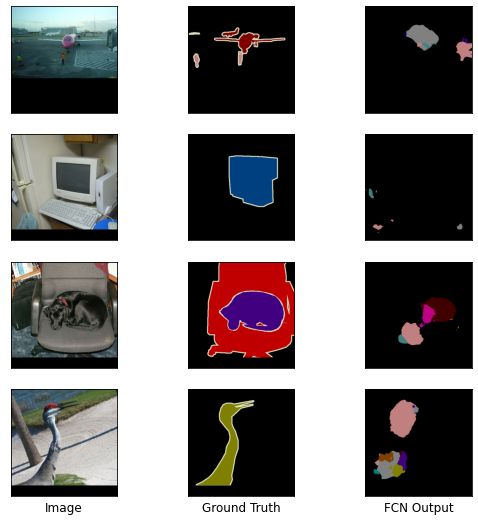

In [44]:
colormaparr = np.array(colormap).astype('uint8')
    
def predict(img): # Predict the output of FCN
    img = img.convert("RGB")
    img = tfs.ToTensor()(img)
    img = Variable(img.unsqueeze(0)).cuda()
    with torch.no_grad():
      resnet_output = FCN_net(img)
    pred = resnet_output.max(1)[1].squeeze().cpu().data.numpy()
    pred = colormaparr[pred]
    pred = Image.fromarray(pred)
    return pred

size = 224
num_image = 4
_, figs = plt.subplots(num_image, 3, figsize=(9, 9))
image_full, label_full = read_images(voc_root)
# image_full, label_full = read_images(voc_root, train = False)
offset = 0
for i in range(num_image):
  img_data = Image.open(image_full[i + offset])
  label_data = Image.open(label_full[i + offset])
  img_data, label_data = crop(img_data, label_data, 416, 416)
  pred = predict(img_data)
  # pred.save('/content/output image/image_output.jpg')

  figs[i, 0].imshow(img_data)
  figs[i, 0].axes.get_xaxis().set_visible(False)  
  figs[i, 0].axes.get_yaxis().set_visible(False)

  figs[i, 1].imshow(label_data)                    
  figs[i, 1].axes.get_xaxis().set_visible(False)  
  figs[i, 1].axes.get_yaxis().set_visible(False)

  figs[i, 2].imshow(pred)                         
  figs[i, 2].axes.get_xaxis().set_visible(False)  
  figs[i, 2].axes.get_yaxis().set_visible(False) 

figs[num_image-1, 0].set_title("Image", y=-0.2)
figs[num_image-1, 1].set_title("Ground Truth", y=-0.2)
figs[num_image-1, 2].set_title("FCN Output", y=-0.2)